In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm

%matplotlib inline

In [41]:
%run utils.py

In [22]:
path = 'data/requests.uniq.train'
train = read_queries(path)
path = 'data/requests.uniq.test'
test = read_queries(path)
train[:5], test[:5]

([['сибирские', 'сети', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карте', 'россии'],
  ['ноофен', 'для', 'каких', 'болезней'],
  ['маус', 'хаус', 'спб']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикая', 'вишня'],
  ['тася', 'кривун', 'танцы', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']])

In [56]:
len(train), len(test)

(51352, 21173)

In [58]:
len(test) / 100 / 60

3.528833333333333

### LSTM с различными эмбеддингами

In [9]:
emb_1 = KeyedVectors.load_word2vec_format("cc.ru.300.vec")

In [4]:
emb = KeyedVectors.load_word2vec_format("wiki.ru.vec")

In [15]:
emb_2 = KeyedVectors.load_word2vec_format("ft_native_300_ru_wiki_lenta_lower_case.vec")

In [16]:
len(emb.vocab), len(emb_1.vocab), len(emb_2.vocab)

(1888423, 600000, 1572343)

In [17]:
len(emb['кот']), len(emb_1['кот']), len(emb_2['кот'])

(300, 300, 300)

In [13]:
emb['кот'][:10]

array([ 0.27378 ,  0.11676 ,  0.035767, -0.12235 ,  0.13553 , -0.15986 ,
        0.21151 ,  0.045899,  0.11613 ,  0.041385], dtype=float32)

In [14]:
emb_1['кот'][:10]

array([ 0.2247, -0.122 , -0.0671, -0.1001, -0.0297, -0.1969,  0.2059,
        0.0064,  0.006 , -0.0467], dtype=float32)

In [18]:
emb_2['кот'][:10]

array([-0.07867 , -0.1209  ,  0.17033 , -0.26766 , -0.47554 ,  0.013102,
       -0.020578, -0.50883 , -0.21604 ,  0.47134 ], dtype=float32)

In [31]:
emb_size = 300

train_part, valid_part = split_to_train_and_validation(train)
print(len(train_part), len(valid_part))

41081 10271


In [25]:
import keras
import keras.layers as L

Using TensorFlow backend.


In [27]:
def build_model(emb_size=300, hid_size=128):
    
    l_input = L.Input(shape=[None, emb_size], name='input')
    l_lstm = L.LSTM(units=hid_size)(l_input)
    
    output_layer = L.Dense(emb_size)(l_lstm)
    
    model = keras.models.Model(inputs=[l_input], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               38700     
Total params: 258,348
Trainable params: 258,348
Non-trainable params: 0
_________________________________________________________________


In [34]:
train_prefixs, train_next_words, train_lost = transform(emb_1, train_part)
valid_prefixs, valid_next_words, val_lost = transform(emb_1, valid_part)

train_prefixs = np.array(train_prefixs)
train_next_words = np.array(train_next_words)
valid_prefixs = np.array(valid_prefixs)
valid_next_words = np.array(valid_next_words)
len(train_prefixs), len(valid_prefixs), train_lost, val_lost

(121818, 30650, 15279, 3847)

In [35]:
batch_size = 256
epochs = 20          
steps_per_epoch = 500 

model = build_model()

history = model.fit_generator(iterate_minibatches(emb_1, emb_size, train_prefixs, train_next_words, batch_size, cycle=True), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(emb_1, emb_size, valid_prefixs, valid_next_words, batch_size, cycle=True),
                    validation_steps=len(valid_prefixs) // batch_size
                   )

Epoch 1/20
500/500 [==============================] - 27s 55ms/step - loss: 0.0105 - mean_absolute_error: 0.0636 - val_loss: 0.0104 - val_mean_absolute_error: 0.0640
Epoch 2/20
500/500 [==============================] - 24s 48ms/step - loss: 0.0102 - mean_absolute_error: 0.0628 - val_loss: 0.0103 - val_mean_absolute_error: 0.0637
Epoch 3/20
500/500 [==============================] - 24s 49ms/step - loss: 0.0101 - mean_absolute_error: 0.0625 - val_loss: 0.0103 - val_mean_absolute_error: 0.0637
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0099 - mean_absolute_error: 0.0620 - val_loss: 0.0102 - val_mean_absolute_error: 0.0635
Epoch 5/20
500/500 [==============================] - 24s 47ms/step - loss: 0.0099 - mean_absolute_error: 0.0620 - val_loss: 0.0102 - val_mean_absolute_error: 0.0635
Epoch 6/20
500/500 [==============================] - 23s 46ms/step - loss: 0.0098 - mean_absolute_error: 0.0617 - val_loss: 0.0099 - val_mean_absolute_error: 0.0622
Epoc

In [69]:
test_prefixs, test_next_words, test_lost = transform(emb_1, test)
test_prefixs = np.array(test_prefixs)
test_next_words = np.array(test_next_words)
len(test_prefixs), test_lost

(62293, 7853)

In [82]:
def draw_dist(emb, model, prefixs, next_words, bound=5, to_use=512):
    indices = np.arange(len(prefixs))
    lens = np.array(list(map(len, test_prefixs)))
    lens = lens[indices]
    lens = np.hstack([indices.reshape(-1, 1), lens.reshape(-1, 1)])
    indices = np.array(sorted(lens, key=lambda x : x[1]))
    changes = []
    i = 0
    while i < len(indices):
        changes.append(i)
        while i < len(indices) and indices[i][1] == len(changes):
            i += 1
    indices = indices[:, 0]
    groups = []
    for i in range(bound):
        left = changes[i]
        right = min(changes[i+1], left+to_use)
        groups.append(indices[left:right])
    res = []
    for i in range(bound):
        X = as_matrix(emb, emb_size, prefixs[groups[i]])
        y = as_matrix_target(emb, emb_size, next_words[groups[i]])
        pred = model.predict(X)
        accr = 0
        count = 0
        for j, k in enumerate(pred):
            if emb.most_similar([k], topn=1)[0][0] == emb.most_similar([y[j]], topn=1)[0][0]:
                accr += 1
            count += 1
        res.append(accr / count)
        print(accr / count)
    return res

In [84]:
first = draw_dist(emb_1, model, test_prefixs, test_next_words, bound=10)

0.0703125
0.091796875
0.091796875
0.095703125
0.09375
0.125
0.12109375
0.095703125
0.072265625
0.06552706552706553


In [50]:
calculate_accuracy(model, emb_1, emb_size, test_lost, 256, test_prefixs, test_next_words)

In progress 1280 / 62293, accuracy = 0.06328125


KeyboardInterrupt: 

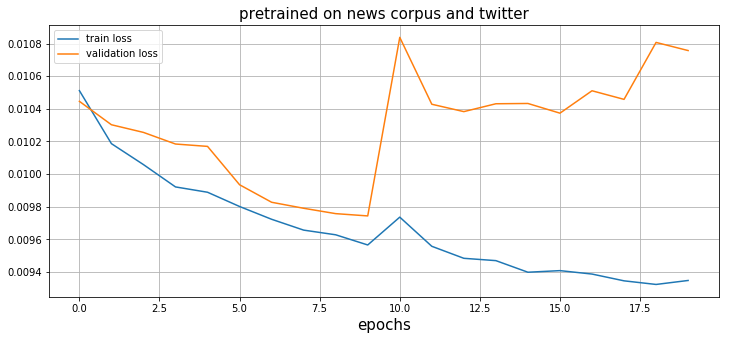

In [64]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('pretrained on news corpus and twitter', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [43]:
train_prefixs, train_next_words, train_lost = transform(emb, train_part)
valid_prefixs, valid_next_words, val_lost = transform(emb, valid_part)

train_prefixs = np.array(train_prefixs)
train_next_words = np.array(train_next_words)
valid_prefixs = np.array(valid_prefixs)
valid_next_words = np.array(valid_next_words)
len(train_prefixs), len(valid_prefixs), train_lost, val_lost

(121610, 30589, 15487, 3908)

In [44]:
model_1 = build_model()

history_1 = model_1.fit_generator(iterate_minibatches(emb, emb_size, train_prefixs, train_next_words, batch_size, cycle=True), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(emb, emb_size, valid_prefixs, valid_next_words, batch_size, cycle=True),
                    validation_steps=len(valid_prefixs) // batch_size
                   )

Epoch 1/20
500/500 [==============================] - 27s 53ms/step - loss: 0.0625 - mean_absolute_error: 0.1942 - val_loss: 0.0625 - val_mean_absolute_error: 0.1947
Epoch 2/20
500/500 [==============================] - 25s 49ms/step - loss: 0.0603 - mean_absolute_error: 0.1902 - val_loss: 0.0609 - val_mean_absolute_error: 0.1917
Epoch 3/20
500/500 [==============================] - 24s 48ms/step - loss: 0.0596 - mean_absolute_error: 0.1888 - val_loss: 0.0602 - val_mean_absolute_error: 0.1902
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0592 - mean_absolute_error: 0.1879 - val_loss: 0.0599 - val_mean_absolute_error: 0.1895
Epoch 5/20
500/500 [==============================] - 25s 50ms/step - loss: 0.0588 - mean_absolute_error: 0.1871 - val_loss: 0.0597 - val_mean_absolute_error: 0.1890
Epoch 6/20
500/500 [==============================] - 24s 48ms/step - loss: 0.0586 - mean_absolute_error: 0.1866 - val_loss: 0.0591 - val_mean_absolute_error: 0.1878
Epoc

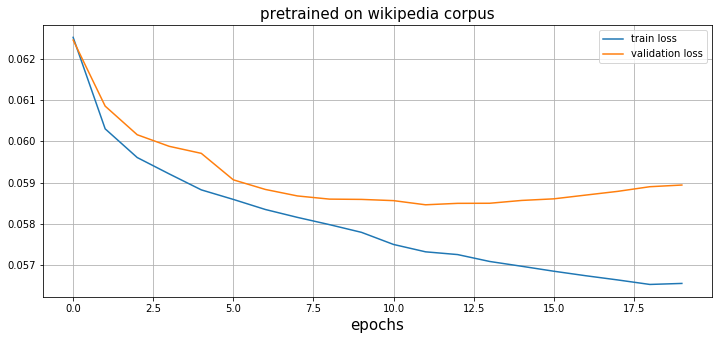

In [61]:
plt.figure(figsize=(12, 5))
plt.plot(history_1.history['loss'], label='train loss')
plt.plot(history_1.history['val_loss'], label='validation loss')
plt.legend()
plt.title('pretrained on wikipedia corpus', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.grid()
plt.show()

In [85]:
test_prefixs, test_next_words, test_lost = transform(emb, test)
test_prefixs = np.array(test_prefixs)
test_next_words = np.array(test_next_words)
len(test_prefixs), test_lost

(62268, 7878)

In [86]:
second = draw_dist(emb, model_1, test_prefixs, test_next_words, bound=10)

0.05078125
0.060546875
0.07421875
0.0859375
0.09375
0.09765625
0.09375
0.08984375
0.0703125
0.04281345565749235


In [47]:
calculate_accuracy(model_1, emb, emb_size, test_lost, 256, test_prefixs, test_next_words)

In progress 1280 / 62268, accuracy = 0.040625


KeyboardInterrupt: 

In [51]:
train_prefixs, train_next_words, train_lost = transform(emb_2, train_part)
valid_prefixs, valid_next_words, val_lost = transform(emb_2, valid_part)

train_prefixs = np.array(train_prefixs)
train_next_words = np.array(train_next_words)
valid_prefixs = np.array(valid_prefixs)
valid_next_words = np.array(valid_next_words)
len(train_prefixs), len(valid_prefixs), train_lost, val_lost

(129582, 32679, 7515, 1818)

In [52]:
model_2 = build_model()

history_2 = model_2.fit_generator(iterate_minibatches(emb_2, emb_size, train_prefixs, train_next_words, batch_size, cycle=True), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(emb_2, emb_size, valid_prefixs, valid_next_words, batch_size, cycle=True),
                    validation_steps=len(valid_prefixs) // batch_size
                   )

Epoch 1/20
500/500 [==============================] - 38s 75ms/step - loss: 0.0506 - mean_absolute_error: 0.1750 - val_loss: 0.0501 - val_mean_absolute_error: 0.1736
Epoch 2/20
500/500 [==============================] - 27s 54ms/step - loss: 0.0488 - mean_absolute_error: 0.1713 - val_loss: 0.0490 - val_mean_absolute_error: 0.1713
Epoch 3/20
500/500 [==============================] - 23s 47ms/step - loss: 0.0482 - mean_absolute_error: 0.1700 - val_loss: 0.0485 - val_mean_absolute_error: 0.1704
Epoch 4/20
500/500 [==============================] - 32s 65ms/step - loss: 0.0479 - mean_absolute_error: 0.1692 - val_loss: 0.0483 - val_mean_absolute_error: 0.1698
Epoch 5/20
500/500 [==============================] - 33s 66ms/step - loss: 0.0476 - mean_absolute_error: 0.1685 - val_loss: 0.0480 - val_mean_absolute_error: 0.1693
Epoch 6/20
500/500 [==============================] - 33s 65ms/step - loss: 0.0474 - mean_absolute_error: 0.1680 - val_loss: 0.0479 - val_mean_absolute_error: 0.1689
Epoc

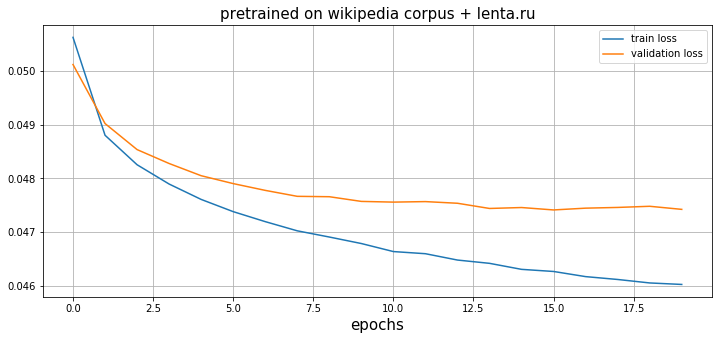

In [62]:
plt.figure(figsize=(12, 5))
plt.plot(history_2.history['loss'], label='train loss')
plt.plot(history_2.history['val_loss'], label='validation loss')
plt.legend()
plt.title('pretrained on wikipedia corpus + lenta.ru', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.grid()
plt.show()

In [87]:
test_prefixs, test_next_words, test_lost = transform(emb_2, test)
test_prefixs = np.array(test_prefixs)
test_next_words = np.array(test_next_words)
len(test_prefixs), test_lost

(66351, 3795)

In [88]:
third = draw_dist(emb_2, model_2, test_prefixs, test_next_words, bound=10)

0.02734375
0.046875
0.07421875
0.06640625
0.08203125
0.09765625
0.08984375
0.064453125
0.0625
0.046703296703296704


In [55]:
calculate_accuracy(model_2, emb_2, emb_size, test_lost, 256, test_prefixs, test_next_words)

In progress 1536 / 66351, accuracy = 0.029947916666666668


KeyboardInterrupt: 

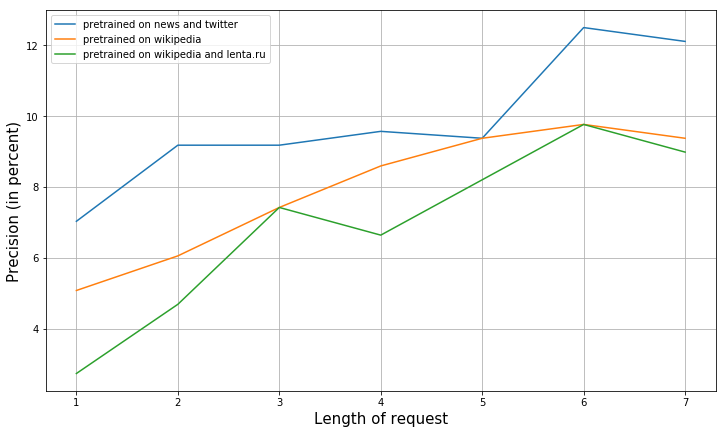

In [98]:
plt.figure(figsize=(12, 7))
bound = 7
grid = np.arange(1, bound+1, 1)

plt.plot(grid, 100 * np.array(first)[:len(grid)], label='pretrained on news and twitter')
plt.plot(grid, 100 * np.array(second)[:len(grid)] , label='pretrained on wikipedia')
plt.plot(grid, 100 * np.array(third)[:len(grid)], label='pretrained on wikipedia and lenta.ru')
plt.xlabel('Length of request', fontsize=15)
plt.ylabel('Precision (in percent)', fontsize=15)
plt.grid()
plt.legend()
plt.show()